# Imports

In [24]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from itertools import accumulate

# Gillespies Algorithm

In [17]:
def run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time=500, random_seed=None):

    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
        
    # Initialize compartments
    X = N - infected_init - recovered_init
    Y = infected_init
    Z = recovered_init

    # Define events
    def Birth(X):
        X += 1
        return X

    def GetInfected(X, Y):
        Y += 1
        X -= 1
        return X, Y

    def Recover(Y, Z):
        Y -= 1
        Z += 1
        return Y, Z

    def DieSusceptible(X):
        X -= 1
        return X

    def DieInfected(Y):
        Y -= 1
        return Y

    def DieRecovered(Z):
        Z -= 1
        return Z

    # Define event chance
# Define event chance
    def GetNextEventTime(event_rate):
        if event_rate > 0:
            delta_t = (-1 / event_rate) * (np.log(random.uniform(0, 1)))
            return delta_t
        else:
            return float('inf')  # Set a large value for next event time if event rate is zero

    def GetRates(X, Y, Z, N, beta, gamma, mu):
        birth_rate = mu * N
        transmission_rate = beta * ((X * Y) / N)
        recovery_rate = gamma * Y
        X_death_rate = mu * X
        Y_death_rate = mu * Y
        Z_death_rate = mu * Z
        return [birth_rate, transmission_rate, recovery_rate, X_death_rate, Y_death_rate, Z_death_rate]

    # Initialize simulation
    data = []
    time = 0

    while time < max_time:
        rates = GetRates(X, Y, Z, N, beta, gamma, mu)

        # Store data
        data.append([time, X, Y, Z])
        next_event_times = []

        for rate in rates:
            next_event_times.append(GetNextEventTime(rate))

        next_event_time = min(next_event_times)
        index_next_event = next_event_times.index(next_event_time)

        time += next_event_time

        # Choose event to execute according to minimal delta_t
        if index_next_event == 0:
            X = Birth(X)
        elif index_next_event == 1:
            X, Y = GetInfected(X, Y)
        elif index_next_event == 2:
            Y, Z = Recover(Y, Z)
        elif index_next_event == 3:
            X = DieSusceptible(X)
        elif index_next_event == 4:
            Y = DieInfected(Y)
        else:
            Z = DieRecovered(Z)

        N = X + Y + Z  # Update N

    # Extract data
    time_series = [entry[0] for entry in data]
    X_series = [entry[1] for entry in data]
    Y_series = [entry[2] for entry in data]
    Z_series = [entry[3] for entry in data]

    return time_series, X_series, Y_series, Z_series

# SIR Model

In [18]:
# Define the deterministic SIR model
def SIR_model(y, t, beta, gamma, mu, N):
    S, I, R = y
    dSdt = mu * N - beta * S * I / N - mu * S
    dIdt = beta * S * I / N - mu * I - gamma * I
    dRdt = gamma * I - mu * R
    return [dSdt, dIdt, dRdt]

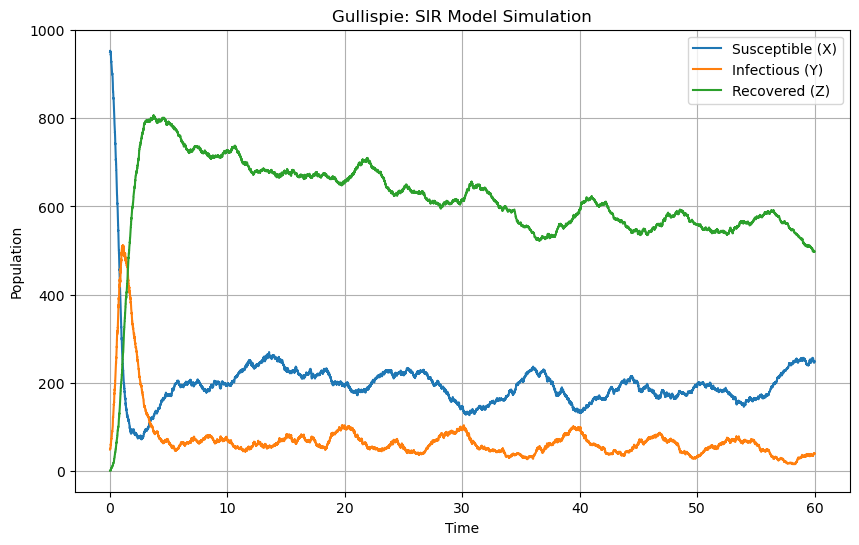

In [19]:
# Example usage of the function
beta = 5
gamma = 1
mu = 0.1
N = 1000
infected_init = 49
recovered_init = 1
max_time = 60
random_seed = 42

# Unpack the results
time_series, X_series, Y_series, Z_series =  run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed)
#Plot
plt.figure(figsize=(10, 6))
plt.plot(time_series, X_series, label='Susceptible (X)')
plt.plot(time_series, Y_series, label='Infectious (Y)')
plt.plot(time_series, Z_series, label='Recovered (Z)')
plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Gullispie: SIR Model Simulation')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# First Experiment - Changing Seeding

In [20]:
# Run the simulation with different random seeds
random_seeds = [42, 123, 987, 456, 789]  # You can change these values
simulation_results = []

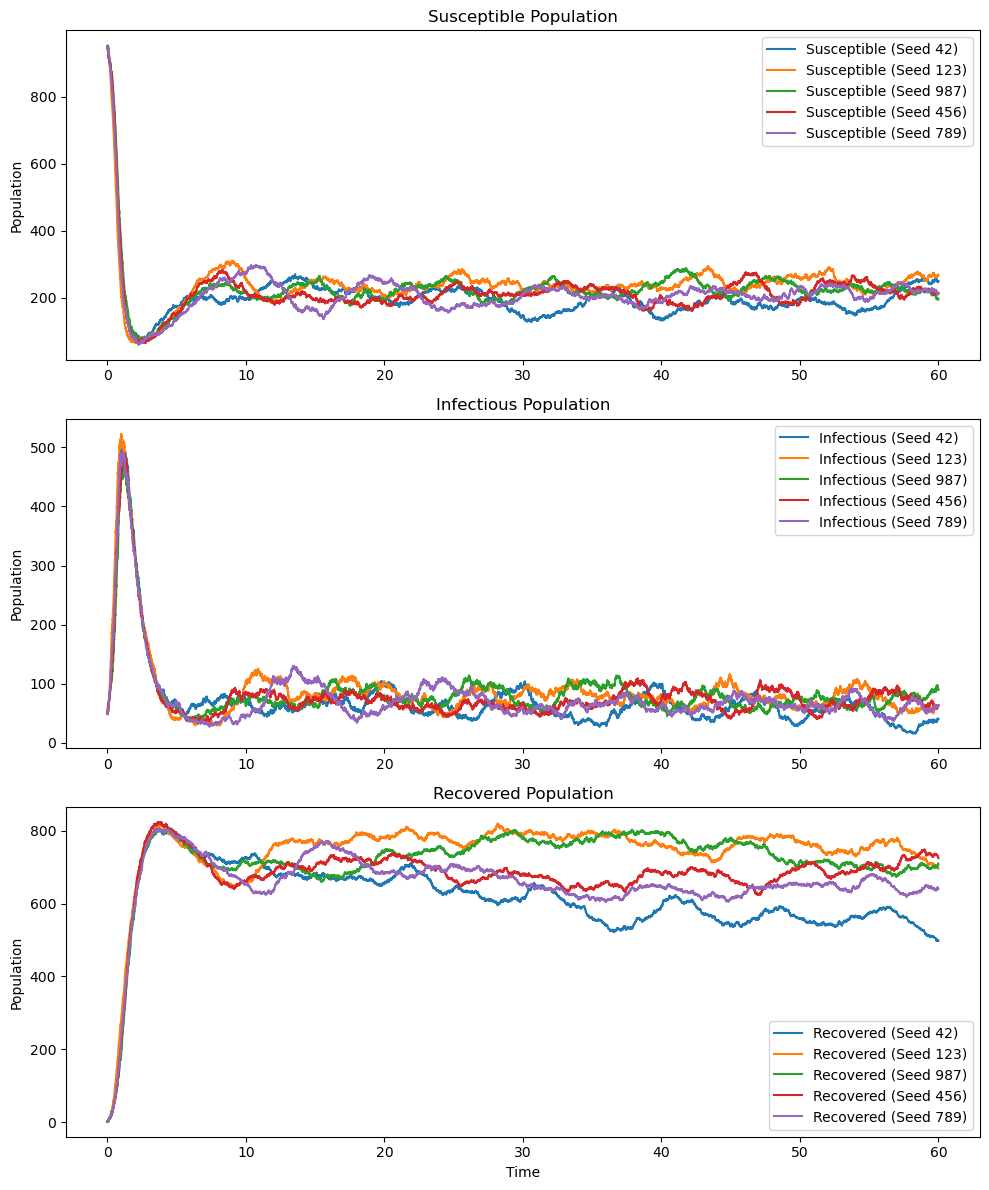

In [21]:
for seed in random_seeds:
    time_series, X_series, Y_series, Z_series = run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=seed)
    simulation_results.append((time_series, X_series, Y_series, Z_series))

# Create subplots for infected, susceptible, and recovered
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Plot the results for different random seeds
for i, seed in enumerate(random_seeds):
    axes[0].plot(simulation_results[i][0], simulation_results[i][1], label=f'Susceptible (Seed {seed})')
    axes[1].plot(simulation_results[i][0], simulation_results[i][2], label=f'Infectious (Seed {seed})')
    axes[2].plot(simulation_results[i][0], simulation_results[i][3], label=f'Recovered (Seed {seed})')

# Set titles and labels for each subplot
axes[0].set_title('Susceptible Population')
axes[0].set_ylabel('Population')
axes[0].legend()

axes[1].set_title('Infectious Population')
axes[1].set_ylabel('Population')
axes[1].legend()

axes[2].set_title('Recovered Population')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Population')
axes[2].legend()

plt.tight_layout()
plt.show()

# Variability

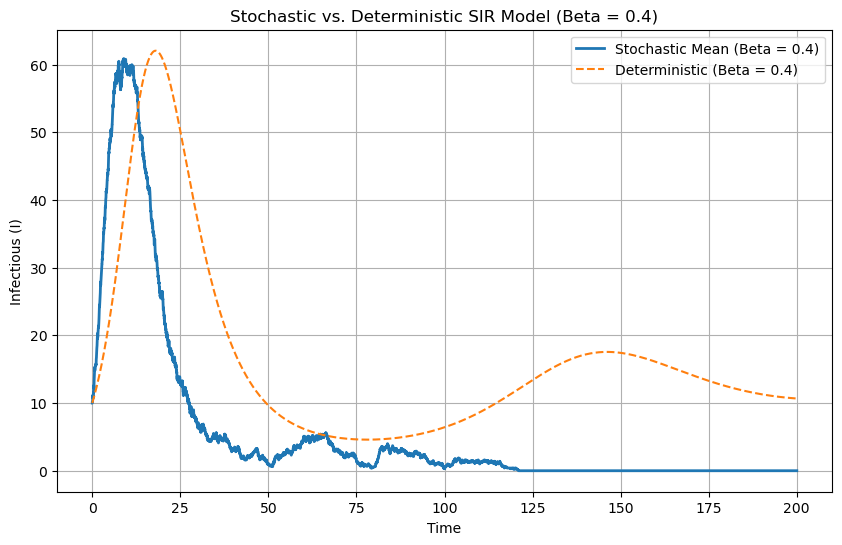

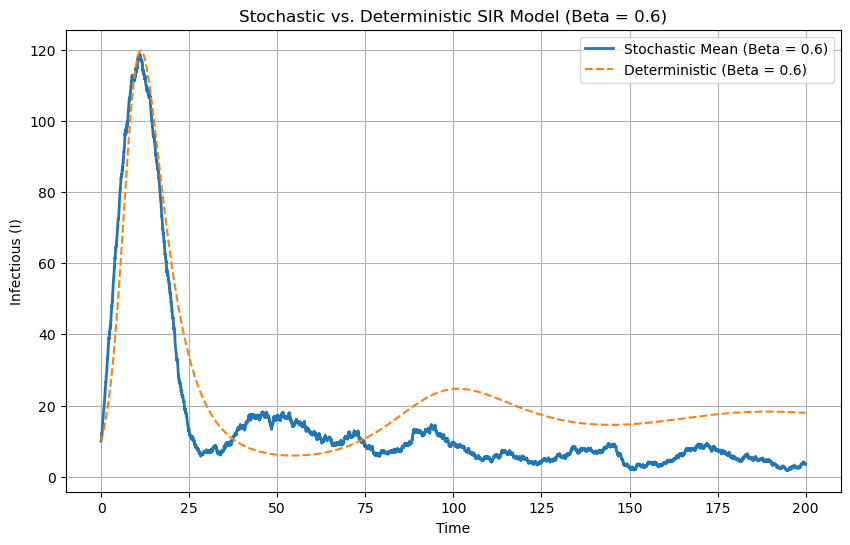

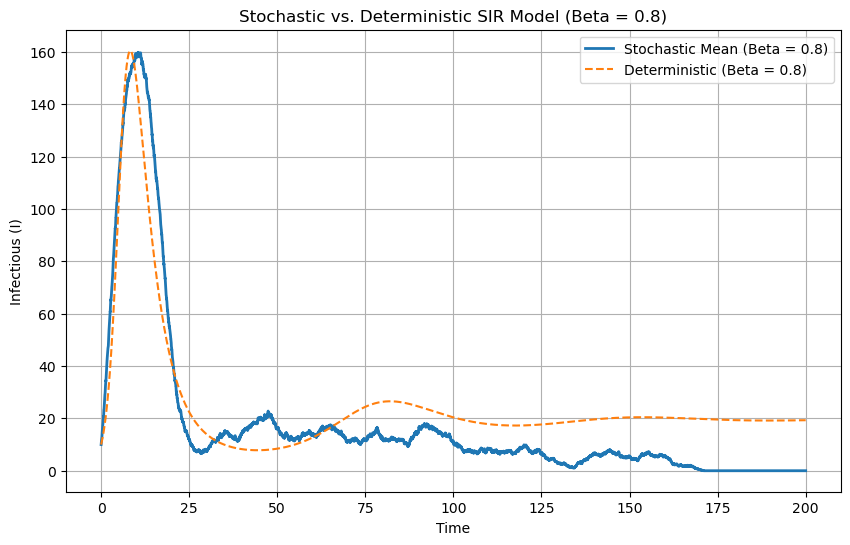

In [22]:
# Define parameters
beta_values = [0.4, 0.6, .8]  # Example beta values
gamma = 0.2
mu = 1/70
N = 400
infected_init = 10
S0 = N - infected_init
recovered_init = 0
t = np.linspace(0, 200, 10000)

# Storage for results
mean_stochastic_I = []

# Loop over beta values
for beta in beta_values:
    # Generate stochastic realizations
    num_simulations = 10
    stochastic_I_realizations = []

    for _ in range(num_simulations):
        # Initialize compartments
        X = N - infected_init - recovered_init
        Y = infected_init
        Z = recovered_init

        # Initialize lists to store population values
        X_values = [X]
        Y_values = [Y]
        Z_values = [Z]

        # Time increment
        dt = t[1] - t[0]

        for _ in range(1, len(t)):
            # Calculate rates
            rates = [
                mu * N,                           # Birth rate
                beta * X * Y / N,                 # Infection rate
                gamma * Y,                        # Recovery rate
                mu * X,                           # Death rate for susceptible
                mu * Y,                           # Death rate for infected
                mu * Z                            # Death rate for recovered
            ]

            # Calculate total rate
            total_rate = sum(rates)

            # Calculate time until the next event
            time_until_event = np.random.exponential(1 / total_rate)

            # Choose the event that happens next
            event = np.random.choice(6, p=[rates[i] / total_rate for i in range(6)])

            # Update compartments based on the chosen event
            if event == 0:
                X += 1
            elif event == 1:
                X -= 1
                Y += 1
            elif event == 2:
                Y -= 1
                Z += 1
            elif event == 3:
                X -= 1
            elif event == 4:
                Y -= 1
            else:
                Z -= 1

            # Append the updated values to the lists
            X_values.append(X)
            Y_values.append(Y)
            Z_values.append(Z)

        # Append the results of a single stochastic realization to the list
        stochastic_I_realizations.append(Y_values)

    # Calculate the mean of stochastic realizations
    mean_I = np.mean(stochastic_I_realizations, axis=0)
    mean_stochastic_I.append(mean_I)

    # Integrate the deterministic SIR model for comparison
    sol = odeint(SIR_model, [S0, infected_init, recovered_init], t, args=(beta, gamma, mu, N))
    deterministic_I = sol[:, 1]

    # Plot individual stochastic realizations, the mean, and deterministic SIR model
    plt.figure(figsize=(10, 6))
#     for i in range(num_simulations):
#         plt.plot(t, stochastic_I_realizations[i], label=f'Stochastic Realization {i + 1}', alpha=0.5)
    plt.plot(t, mean_I, label=f'Stochastic Mean (Beta = {beta})', linestyle='-', linewidth=2)
    plt.plot(t, deterministic_I, label=f'Deterministic (Beta = {beta})', linestyle='--')

    plt.xlabel('Time')
    plt.ylabel('Infectious (I)')
    plt.title(f'Stochastic vs. Deterministic SIR Model (Beta = {beta})')
    plt.legend()
    plt.grid(True)
    plt.show()


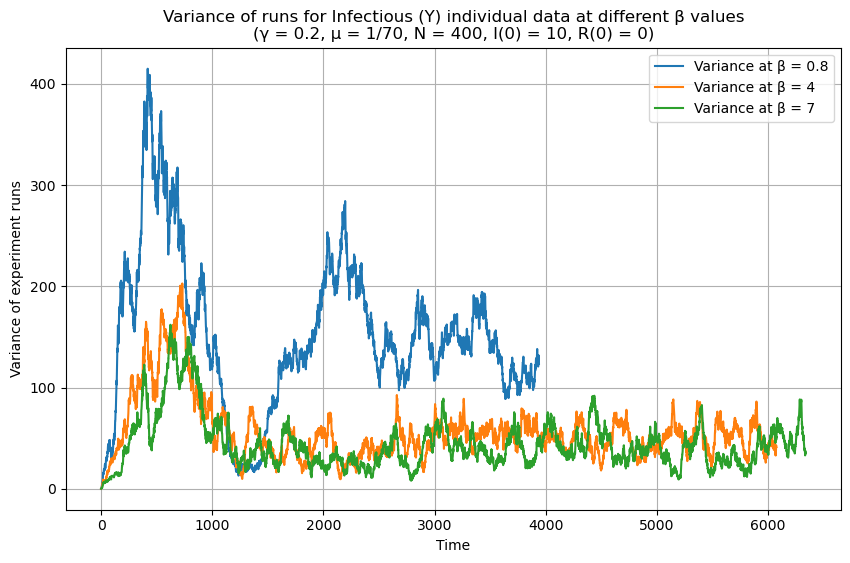

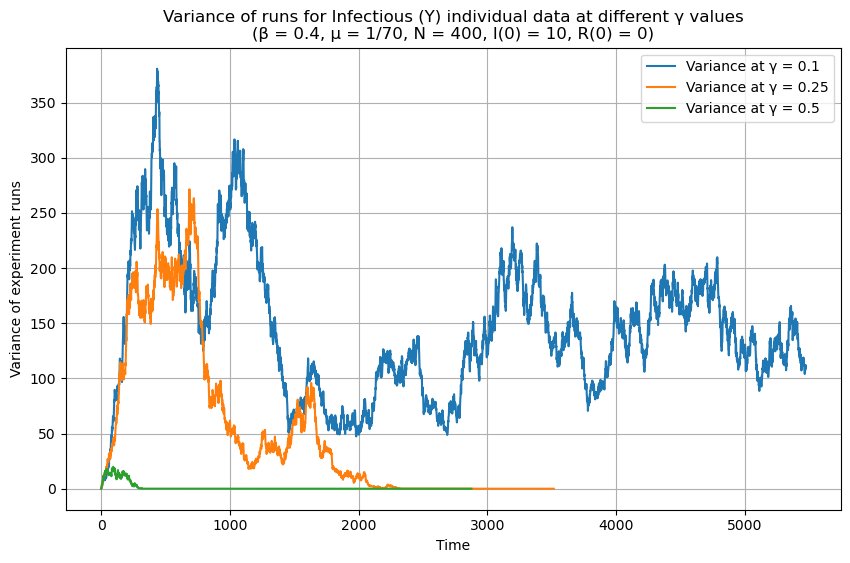

In [32]:
#Variance between runs for different beta values

beta_values = [0.8, 4, 7]
gamma = 0.2
mu = 1/70
N = 400
infected_init = 10
S0 = N - infected_init
recovered_init = 0
random_seeds = [42, 123, 987, 456, 789, 672, 93, 102, 501, 371, 600, 877, 201, 755, 200, 645]
plt.figure(figsize=(10, 6))

for beta in beta_values:
    
    all_runs_infectious = []
    
    for seed in random_seeds:
        time_series, _, Y_series, _ =  run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time, seed)
        all_runs_infectious.append(Y_series)
    
    min_length = min(len(series) for series in all_runs_infectious)
    all_runs_infectious = [series[:min_length] for series in all_runs_infectious]
    
    variances = np.var(all_runs_infectious, axis=0)
    time = list(range(0, min_length))
    
    plt.plot(time, variances, label =f'Variance at β = {beta}' )

plt.xlabel('Time')
plt.ylabel('Variance of experiment runs')
plt.title(f'Variance of runs for Infectious (Y) individual data at different β values\n(γ = {gamma}, μ = 1/70, N = {N}, I(0) = {infected_init}, R(0) = {recovered_init})')
plt.legend()
plt.grid(True)
plt.show()


#Variance between runs for different gamma values

beta = 0.4
gamma_values = [0.1, 0.25, 0.5]
mu = 1/70
N = 400
infected_init = 10
S0 = N - infected_init
recovered_init = 0
random_seeds = [42, 123, 987, 456, 789, 672, 93, 102, 501, 371, 600, 877, 201, 755, 200, 645]
plt.figure(figsize=(10, 6))

for gamma in gamma_values:
    
    all_runs_infectious = []
    
    for seed in random_seeds:
        time_series, _, Y_series, _ =  run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time, seed)
        all_runs_infectious.append(Y_series)
    
    min_length = min(len(series) for series in all_runs_infectious)
    all_runs_infectious = [series[:min_length] for series in all_runs_infectious]
    
    variances = np.var(all_runs_infectious, axis=0)
    time = list(range(0, min_length))
    
    plt.plot(time, variances, label =f'Variance at γ = {gamma}' )

plt.xlabel('Time')
plt.ylabel('Variance of experiment runs')
plt.title(f'Variance of runs for Infectious (Y) individual data at different γ values\n(β = {beta}, μ = 1/70, N = {N}, I(0) = {infected_init}, R(0) = {recovered_init})')
plt.legend()
plt.grid(True)
plt.show()


#Variance between runs for different population values
# beta = 0.6
# gamma = 0.2
# mu = 1/70
# N_values = [100, 1000, 10000]
# infected_init = 10
# S0 = N - infected_init
# recovered_init = 0
# random_seeds = [42, 123, 987, 456, 789, 672, 93, 102, 501, 371, 600, 877, 201, 755, 200, 645]
# plt.figure(figsize=(10, 6))

# for N in N_values:
    
#     all_runs_infectious = []
    
#     for seed in random_seeds:
#         time_series, _, Y_series, _ =  run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time, seed)
#         all_runs_infectious.append(Y_series)
    
#     min_length = min(len(series) for series in all_runs_infectious)
#     all_runs_infectious = [series[:min_length] for series in all_runs_infectious]
    
#     variances = np.var(all_runs_infectious, axis=0)
#     time = list(range(0, min_length))
    
#     plt.plot(time, variances, label =f'Variance at N = {N}' )

# plt.xlabel('Time')
# plt.ylabel('Variance of experiment runs')
# plt.title(f'Variance of runs for Infectious (Y) individual data at different γ values\n(β = {beta}, γ = {gamma}, μ = 1/70, I(0) = infected_init, R(0) = recovered_init)')
# plt.legend()
# plt.grid(True)
# plt.show()

# Covariance:

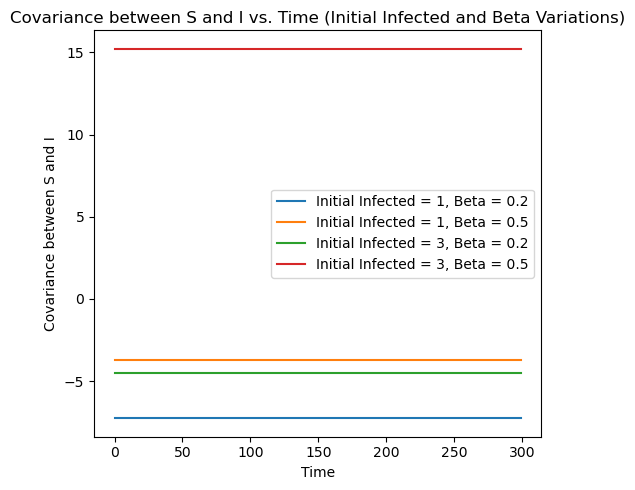

In [28]:
## Function to calculate covariance between S and I
def calculate_covariance(S_series, I_series):
    return np.cov(S_series, I_series)[0, 1]

# Define parameter ranges to explore
beta_values = [0.2, 0.5]  # Example beta values
gamma = 0.5 # Fixed gamma value
mu = 1/70 # Fixed mu value

# Define initial infected values to explore
initial_infected_values = [1, 3]  # Example initial infected values

# Other simulation settings
N = 100
recovered_init = 1
max_time = 300
num_simulations = 20  # Number of stochastic simulations for each parameter combination

# Storage for results
parameter_settings = []

mean_infectious_populations = []
variances = []
covariances = []

# Loop over initial infected values
for infected_init in initial_infected_values:
    # Loop over beta values
    for beta in beta_values:
        # Store current parameter combination
        parameter_settings.append({"beta": beta, "gamma": gamma, "mu": mu, "infected_init": infected_init})

        # Arrays to store simulation results
        infectious_populations = np.zeros((num_simulations, max_time))
        susceptible_populations = np.zeros((num_simulations, max_time))

        # Run multiple simulations for the current parameter combination
        for i in range(num_simulations):
            time_series, X_series, Y_series, Z_series = run_sir_simulation(
                beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed=i
            )

            # Truncate the series to match max_time
            time_series = time_series[:max_time]
            X_series = X_series[:max_time]
            Y_series = Y_series[:max_time]
            Z_series = Z_series[:max_time]

            # Store infectious and susceptible populations over time
            infectious_populations[i, :len(Y_series)] = Y_series
            susceptible_populations[i, :len(X_series)] = X_series

        # Calculate statistics for the current parameter combination
        mean_infectious = np.mean(infectious_populations, axis=0)
        var_infectious = np.var(infectious_populations, axis=0)
        covariance_si = calculate_covariance(susceptible_populations, infectious_populations)

        # Store results
        mean_infectious_populations.append(mean_infectious)
        variances.append(var_infectious)
        covariances.append(covariance_si)

# Visualization
plt.figure(figsize=(15, 5))

# Plot covariances between susceptible and infectious populations for different initial infected and beta values
plt.subplot(1, 3, 3)
for i, infected_init in enumerate(initial_infected_values):
    for j, beta in enumerate(beta_values):
        label = f'Initial Infected = {infected_init}, Beta = {beta}'
        plt.plot(range(max_time), [covariances[i * len(beta_values) + j]] * max_time, label=label)
plt.xlabel('Time')
plt.ylabel('Covariance between S and I')
plt.title('Covariance between S and I vs. Time (Initial Infected and Beta Variations)')
plt.legend()

plt.tight_layout()
plt.show()


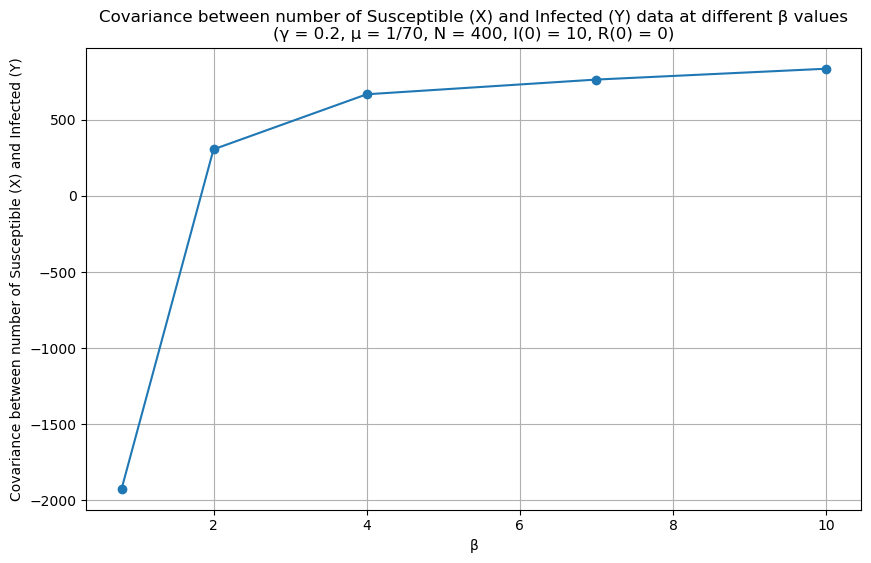

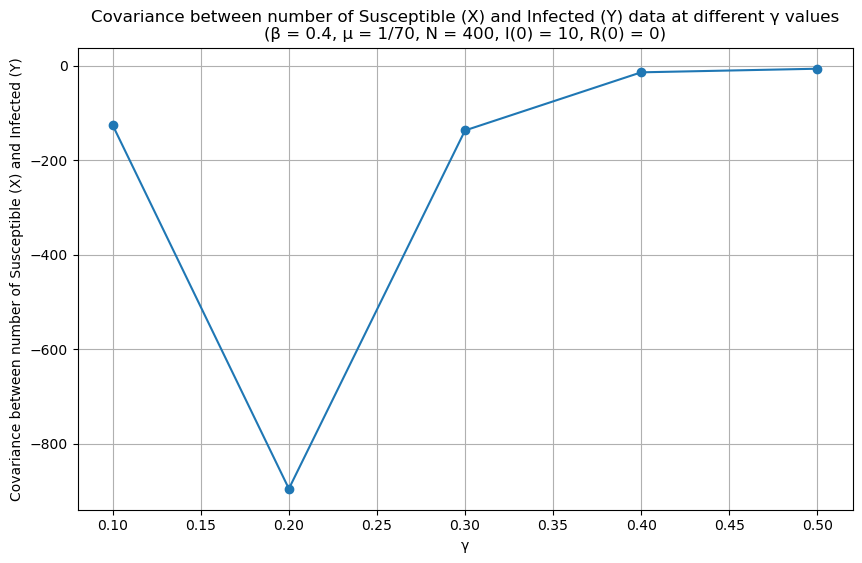

In [50]:
#plot covariances as a function of beta
beta_values = [0.8, 2, 4, 7, 10]
gamma = 0.2
mu = 1/70
N_values = 400
infected_init = 10
S0 = N - infected_init
recovered_init = 0
random_seeds = [42, 123, 987, 456, 789, 672, 93, 102, 501, 371, 600, 877, 201, 755, 200, 645]
plt.figure(figsize=(10, 6))

covariances_per_beta = []

for beta in beta_values:
    
    all_runs_covariances = []
    
    for seed in random_seeds:
        time_series, X_series, Y_series, _ =  run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time, seed)
        all_runs_covariances.append(np.cov(X_series, Y_series)[0, 1])
    
    covariances_per_beta.append(np.mean(all_runs_covariances))
    
plt.plot(beta_values, covariances_per_beta, marker = 'o', linestyle = '-')
plt.xlabel('β')
plt.ylabel('Covariance between number of Susceptible (X) and Infected (Y)')
plt.title(f'Covariance between number of Susceptible (X) and Infected (Y) data at different β values\n(γ = {gamma}, μ = 1/70, N = {N}, I(0) = {infected_init}, R(0) = {recovered_init})')
plt.grid(True)
plt.show()



#plot covariances as a function of gamma
beta = 0.4
gamma_values = [0.1, 0.2, 0.3, 0.4, 0.5]
mu = 1/70
N_values = 400
infected_init = 10
S0 = N - infected_init
recovered_init = 0
random_seeds = [42, 123, 987, 456, 789, 672, 93, 102, 501, 371, 600, 877, 201, 755, 200, 645]
plt.figure(figsize=(10, 6))

covariances_per_gamma = []

for gamma in gamma_values:
    
    all_runs_covariances = []
    
    for seed in random_seeds:
        time_series, X_series, Y_series, _ =  run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time, seed)
        all_runs_covariances.append(np.cov(X_series, Y_series)[0, 1])
    
    covariances_per_gamma.append(np.mean(all_runs_covariances))
    
plt.plot(gamma_values, covariances_per_gamma, marker = 'o', linestyle = '-')
plt.xlabel('γ')
plt.ylabel('Covariance between number of Susceptible (X) and Infected (Y)')
plt.title(f'Covariance between number of Susceptible (X) and Infected (Y) data at different γ values\n(β = {beta}, μ = 1/70, N = {N}, I(0) = {infected_init}, R(0) = {recovered_init})')
plt.grid(True)
plt.show()

# Stochastic Resonance

- vary N, beta 

In [ ]:
# Define parameters for the stochastic SIR model
beta_values = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]  # Vary the transmission rate (beta)
N = 500  # Total population size

# Other parameters for both models
gamma = 0.1
mu = 1/70
infected_init = 1
recovered_init = 0
max_time = 500
random_seed = 42

# Initialize lists to store results
stochastic_results = []
deterministic_results = []

# Loop over beta values while keeping N constant
for beta in beta_values:
    # Run simulations for the stochastic SIR model
    time_series, X_series, Y_series, Z_series = run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed)

    stochastic_results.append((beta, N, time_series, Y_series, X_series, Z_series))  # Store results for plotting

    # Time points for the deterministic model
    t_deterministic = np.linspace(0, max_time, len(time_series))

    # Initial conditions for the deterministic model
    S0_deterministic = N - infected_init
    I0_deterministic = infected_init
    R0_deterministic = 0
    y0_deterministic = [S0_deterministic, I0_deterministic, R0_deterministic]

    # Solve the deterministic SIR model
    sol_deterministic = odeint(SIR_model, y0_deterministic, t_deterministic, args=(beta, gamma, mu, N))
    S_deterministic, I_deterministic, R_deterministic = sol_deterministic[:, 0], sol_deterministic[:, 1], sol_deterministic[:, 2]

    deterministic_results.append((beta, N, t_deterministic, I_deterministic, S_deterministic, R_deterministic))  # Store results for plotting

# Plot the results for the stochastic and deterministic SIR models (varying beta)
for beta, N, time_series, Y_series, X_series, Z_series in stochastic_results:
    plt.figure(figsize=(12, 6))
    plt.plot(time_series, Y_series, label=f'Stochastic Infected (N={N}, beta={beta})', linestyle='--', alpha=0.7)
    plt.plot(time_series, X_series, label=f'Stochastic Susceptible (N={N}, beta={beta})', linestyle='--', alpha=0.7)
    plt.plot(time_series, Z_series, label=f'Stochastic Recovered (N={N}, beta={beta})', linestyle='--', alpha=0.7)

    # Find the corresponding deterministic result for this beta and N
    deterministic_result = next(result for result in deterministic_results if result[0] == beta and result[1] == N)
    t_deterministic, I_deterministic, S_deterministic, R_deterministic = deterministic_result[2], deterministic_result[3], deterministic_result[4], deterministic_result[5]

    plt.plot(t_deterministic, I_deterministic, label=f'Deterministic Infected (N={N}, beta={beta})', linestyle='-')
    plt.plot(t_deterministic, S_deterministic, label=f'Deterministic Susceptible (N={N}, beta={beta})', linestyle='-')
    plt.plot(t_deterministic, R_deterministic, label=f'Deterministic Recovered (N={N}, beta={beta})', linestyle='-')

    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title(f'Stochastic vs. Deterministic SIR Models (Beta={beta}, N={N})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Calculate the amplitude of fluctuations for the stochastic SIR model
amplitudes = []

for beta, N, time_series, Y_series, X_series, Z_series in stochastic_results:
    # Calculate the standard deviation (amplitude) of infected individuals
    amplitude = np.std(Y_series)
    amplitudes.append((beta, N, amplitude))

# Plot the amplitudes as a function of beta
beta_values = [result[0] for result in amplitudes]
amplitude_values = [result[2] for result in amplitudes]

plt.figure(figsize=(12, 6))
plt.plot(beta_values, amplitude_values, marker='o', linestyle='-', color='b')
plt.xlabel('Transmission Rate (Beta)')
plt.ylabel('Amplitude of Infected Individuals')
plt.title('Amplitude of Fluctuations in Stochastic SIR Model')
plt.grid(True)
plt.show()


In [ ]:
# Define parameters for the stochastic SIR model
beta_values = [0.4, 0.8, 2]  # Vary the transmission rate (beta)
N_values = [100, 500, 2000]  # Vary the total population size

# Other parameters for both models
gamma = 0.1
mu = 1/70
infected_init = 5
recovered_init = 0
max_time = 500
random_seed = 42

# Initialize lists to store results
stochastic_results = []
deterministic_results = []

# Loop over beta and N combinations
for beta in beta_values:
    for N in N_values:
        # Run simulations for the stochastic SIR model
        time_series, X_series, Y_series, Z_series = run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed)

        stochastic_results.append((beta, N, time_series, Y_series, X_series, Z_series))  # Store results for plotting

        # Time points for the deterministic model
        t_deterministic = np.linspace(0, max_time, len(time_series))

        # Initial conditions for the deterministic model
        S0_deterministic = N - infected_init
        I0_deterministic = infected_init
        R0_deterministic = 0
        y0_deterministic = [S0_deterministic, I0_deterministic, R0_deterministic]

        # Solve the deterministic SIR model
        sol_deterministic = odeint(SIR_model, y0_deterministic, t_deterministic, args=(beta, gamma, mu, N))
        S_deterministic, I_deterministic, R_deterministic = sol_deterministic[:, 0], sol_deterministic[:, 1], sol_deterministic[:, 2]

        deterministic_results.append((beta, N, t_deterministic, I_deterministic, S_deterministic, R_deterministic))  # Store results for plotting

# Plot the results for the stochastic and deterministic SIR models
for beta, N, time_series, Y_series, X_series, Z_series in stochastic_results:
    plt.figure(figsize=(12, 6))
    plt.plot(time_series, Y_series, label=f'Stochastic Infected (N={N}, beta={beta})', linestyle='--', alpha=0.7)
    plt.plot(time_series, X_series, label=f'Stochastic Susceptible (N={N}, beta={beta})', linestyle='--', alpha=0.7)
    plt.plot(time_series, Z_series, label=f'Stochastic Recovered (N={N}, beta={beta})', linestyle='--', alpha=0.7)

    # Find the corresponding deterministic result for this beta and N
    deterministic_result = next(result for result in deterministic_results if result[0] == beta and result[1] == N)
    t_deterministic, I_deterministic, S_deterministic, R_deterministic = deterministic_result[2], deterministic_result[3], deterministic_result[4], deterministic_result[5]

    plt.plot(t_deterministic, I_deterministic, label=f'Deterministic Infected (N={N}, beta={beta})', linestyle='-')
    plt.plot(t_deterministic, S_deterministic, label=f'Deterministic Susceptible (N={N}, beta={beta})', linestyle='-')
    plt.plot(t_deterministic, R_deterministic, label=f'Deterministic Recovered (N={N}, beta={beta})', linestyle='-')

    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title(f'Stochastic vs. Deterministic SIR Models (Beta={beta}, N={N})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Increased Transients

In [ ]:
def run_sir_simulation_phase(beta, gamma, mu, N, infected_init, recovered_init, max_time=500, random_seed=None):

    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)

    # Initialize compartments
    X = N - infected_init - recovered_init
    Y = infected_init
    Z = recovered_init

    # Define events
    def Birth(X):
        X += 1
        return X

    def GetInfected(X, Y):
        Y += 1
        X -= 1
        return X, Y

    def Recover(Y, Z):
        Y -= 1
        Z += 1
        return Y, Z

    def DieSusceptible(X):
        X -= 1
        return X

    def DieInfected(Y):
        Y -= 1
        return Y

    def DieRecovered(Z):
        Z -= 1
        return Z

    # Define event chance
    def GetNextEventTime(event_rate):
        if event_rate > 0:
            delta_t = (-1 / event_rate) * (np.log(random.uniform(0, 1)))
            return delta_t
        else:
            return float('inf')  # Set a large value for the next event time if the event rate is zero

    def GetRates(X, Y, Z, N, beta, gamma, mu):
        birth_rate = mu * N
        transmission_rate = beta * ((X * Y) / N)
        recovery_rate = gamma * Y
        X_death_rate = mu * X
        Y_death_rate = mu * Y
        Z_death_rate = mu * Z
        return [birth_rate, transmission_rate, recovery_rate, X_death_rate, Y_death_rate, Z_death_rate]

    # Initialize simulation
    data = []
    time = 0

    # Lists to store the values for creating a phase-space diagram
    X_values = []
    Y_values = []
    Z_values = []

    while time < max_time:
        rates = GetRates(X, Y, Z, N, beta, gamma, mu)

        # Store data
        data.append([time, X, Y, Z])

        # Store values for the phase-space diagram
        X_values.append(X)
        Y_values.append(Y)
        Z_values.append(Z)

        next_event_times = []

        for rate in rates:
            next_event_times.append(GetNextEventTime(rate))

        next_event_time = min(next_event_times)
        index_next_event = next_event_times.index(next_event_time)

        time += next_event_time

        # Choose the event to execute according to the minimal delta_t
        if index_next_event == 0:
            X = Birth(X)
        elif index_next_event == 1:
            X, Y = GetInfected(X, Y)
        elif index_next_event == 2:
            Y, Z = Recover(Y, Z)
        elif index_next_event == 3:
            X = DieSusceptible(X)
        elif index_next_event == 4:
            Y = DieInfected(Y)
        else:
            Z = DieRecovered(Z)

        N = X + Y + Z  # Update N

    # Extract data
    time_series = [entry[0] for entry in data]
    X_series = [entry[1] for entry in data]
    Y_series = [entry[2] for entry in data]
    Z_series = [entry[3] for entry in data]

    return time_series, X_series, Y_series, Z_series, X_values, Y_values, Z_values


In [ ]:
# Define parameters for the regular SIR model
beta = 0.6
gamma = 0.2
mu = 1 / 70
N = 500
infected_init = 5
recovered_init = 0
max_time = 500
random_seed = 42

# Number of samples
num_samples = 100000

# Run the simulation for the regular SIR model
results = odeint(SIR_model, [N - infected_init - recovered_init, infected_init, recovered_init], np.linspace(0, max_time, num_samples), args=(beta, gamma, mu, N))
X_reg, Y_reg, Z_reg = results.T

# Run the stochastic simulation for the SIR model
simulation_results = run_sir_simulation_phase(beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed)

# Unpack the results from the stochastic simulation
time_series, X_series, Y_series, Z_series, X_values, Y_values, Z_values = simulation_results

# Create a phase-space diagram
plt.figure(figsize=(10, 8))
plt.plot(X_values, Y_values, label='Phase Space (Stochastic)', color='b', alpha=0.7)
plt.plot(X_reg, Y_reg, label='Phase Space (Regular)', color='r', alpha=0.7)
plt.xlabel('Susceptible (X)')
plt.ylabel('Infected (Y)')
plt.title('SIR Phase-Space Diagram (Stochastic vs. Regular)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define a range of values for N and beta to explore
N_values = [250, 500, 1000, 10000]
beta_values = [0.4, 0.6, 0.8]

# Other parameters
gamma = 0.05
mu = 1 / 70
infected_init = 2
recovered_init = 0
max_time = 1000
random_seed = 24
num_samples = 10000

# Create subplots for different combinations of N and beta
fig, axs = plt.subplots(len(N_values), len(beta_values), figsize=(12, 10))
fig.suptitle('Impact of Changing N and Beta on SIR Phase-Space Diagrams')

for i, N in enumerate(N_values):
    for j, beta in enumerate(beta_values):
    
        # Run the simulation for the regular SIR model
        results = odeint(SIR_model, [N - infected_init - recovered_init, infected_init, recovered_init], np.linspace(0, max_time, num_samples), args=(beta, gamma, mu, N))
        X_reg, Y_reg, Z_reg = results.T

        # Run the stochastic simulation for the SIR model
        simulation_results = run_sir_simulation_phase(beta, gamma, mu, N, infected_init, recovered_init, max_time, random_seed)

        # Unpack the results from the stochastic simulation
        time_series, X_series, Y_series, Z_series, X_values, Y_values, Z_values = simulation_results

        # Create a phase-space diagram
        axs[i, j].plot(X_values, Y_values, label='Phase Space (Stochastic)', color='b', alpha=0.5)
        axs[i, j].plot(X_reg, Y_reg, label='Phase Space (Regular)', color='r', alpha=0.7)
        axs[i, j].scatter(X_values[-1], Y_values[-1], c='g', marker='x', label='End (Stochastic)')
        axs[i, j].scatter(X_reg[-1], Y_reg[-1], c='r', marker='o', label='End (Regular)')
        axs[i, j].set_xlabel('Susceptible (X)')
        axs[i, j].set_ylabel('Infected (Y)')
        axs[i, j].set_title(f'N={N}, Beta={beta}')
        axs[i, j].grid(True)
        axs[i, j].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Extinction events 

In [ ]:
def run_sir_simulation(beta, gamma, mu, N, infected_init, recovered_init, max_time=60, random_seed=None):

    if random_seed is not None:
        random.seed(random_seed)
        np.random.seed(random_seed)
        
    # Initialize compartments
    X = N - infected_init - recovered_init
    Y = infected_init
    Z = recovered_init

    # Define events
    def Birth(X):
        X += 1
        return X

    def GetInfected(X, Y):
        Y += 1
        X -= 1
        return X, Y

    def Recover(Y, Z):
        Y -= 1
        Z += 1
        return Y, Z

    def DieSusceptible(X):
        X -= 1
        return X

    def DieInfected(Y):
        Y -= 1
        return Y

    def DieRecovered(Z):
        Z -= 1
        return Z

    # Define event chance
    def GetNextEventTime(event_rate):
        delta_t = (-1 / event_rate) * (np.log(random.uniform(0, 1)))
        return delta_t

    def GetRates(X, Y, Z, N, beta, gamma, mu):
        birth_rate = mu * N
        transmission_rate = beta * ((X * Y) / N)
        recovery_rate = gamma * Y
        X_death_rate = mu * X
        Y_death_rate = mu * Y
        Z_death_rate = mu * Z
        return [birth_rate, transmission_rate, recovery_rate, X_death_rate, Y_death_rate, Z_death_rate]

    # Initialize simulation
    data = []
    time = 0
    ext_timelist = []  # Initialize the list to track extinction times

    while time < max_time:
        rates = GetRates(X, Y, Z, N, beta, gamma, mu)

        # Store data
        data.append([time, X, Y, Z])
        next_event_times = []

        # Check for extinction
        if (X <= 0) or (Y <= 0) or (Z <= 0):
            extinction_time = time
            ext_timelist.append(extinction_time)  # Track extinction time
            break

        for rate in rates:
            next_event_times.append(GetNextEventTime(rate))

        next_event_time = min(next_event_times)
        index_next_event = next_event_times.index(next_event_time)

        time += next_event_time

        # Choose event to execute according to minimal delta_t
        if index_next_event == 0:
            X = Birth(X)
        elif index_next_event == 1:
            X, Y = GetInfected(X, Y)
        elif index_next_event == 2:
            Y, Z = Recover(Y, Z)
        elif index_next_event == 3:
            X = DieSusceptible(X)
        elif index_next_event == 4:
            Y = DieInfected(Y)
        else:
            Z = DieRecovered(Z)

        N = X + Y + Z  # Update N

    # Check if an extinction event occurred
    if ext_timelist:
        print(f"Extinction(s) occurred at time(s): {ext_timelist}")

    # Extract data
    time_series = [entry[0] for entry in data]
    X_series = [entry[1] for entry in data]
    Y_series = [entry[2] for entry in data]
    Z_series = [entry[3] for entry in data]

    return time_series, X_series, Y_series, Z_series, ext_timelist


In [ ]:
# Parameters
gamma = 1
mu = 1/70
N = 400
infected_init = 49
recovered_init = 1
max_time = 190

# Varying values of beta
beta_values = [2, 3, 4, 5, 6]  # Example beta values to vary

# Loop over different beta values
for beta in beta_values:
    extinction_times = []  # Reset the extinction times list
    print(f"Running simulation for beta = {beta}")
    time_series, X_series, Y_series, Z_series, extinction_times = run_sir_simulation(
        beta, gamma, mu, N, infected_init, recovered_init, max_time
    )
    
    # Example: Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(time_series, X_series, label='Susceptible (X)')
    plt.plot(time_series, Y_series, label='Infectious (Y)')
    plt.plot(time_series, Z_series, label='Recovered (Z)')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title(f'Gullispie: SIR Model Simulation (Beta = {beta})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print timestamps of extinctions
    print(f"Extinctions for beta = {beta} occurred at days: {extinction_times}")

# Critical Community Size